# 稀疏数据和嵌入简介

**学习目标：**
* 将影评字符串数据转换为稀疏特征矢量
* 使用稀疏特征矢量实现情感分析线性模型
* 通过将数据投射到二维空间的嵌入来实现情感分析 DNN 模型
* 将嵌入可视化，以便查看模型学到的词语之间的关系

在此练习中，我们将探讨稀疏数据，并使用影评文本数据（来自 [ACL 2011 IMDB 数据集](http://ai.stanford.edu/~amaas/data/sentiment/)）进行嵌入。这些数据已被处理成 `tf.Example` 格式。

In [1]:
from __future__ import print_function

import collections
import io
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython import display
from sklearn import metrics

tf.logging.set_verbosity(tf.logging.ERROR)
train_url = 'https://download.mlcc.google.cn/mledu-datasets/sparse-data-embedding/train.tfrecord'
train_path = tf.keras.utils.get_file(train_url.split('/')[-1], train_url)
test_url = 'https://download.mlcc.google.cn/mledu-datasets/sparse-data-embedding/test.tfrecord'
test_path = tf.keras.utils.get_file(test_url.split('/')[-1], test_url)

40697856/40688441 [==============================] - 263s 6us/step


In [2]:
def _parse_function(record):
  """Extracts features and labels.
  
  Args:
    record: File path to a TFRecord file    
  Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
  """
  features = {
    "terms": tf.VarLenFeature(dtype=tf.string), # terms are strings of varying lengths
    "labels": tf.FixedLenFeature(shape=[1], dtype=tf.float32) # labels are 0 or 1
  }
  
  parsed_features = tf.parse_single_example(record, features)
  
  terms = parsed_features['terms'].values
  labels = parsed_features['labels']

  return  {'terms':terms}, labels

In [3]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(train_path)
# Map features and labels with the parse function.
ds = ds.map(_parse_function)

ds

<MapDataset shapes: ({terms: (?,)}, (1,)), types: ({terms: tf.string}, tf.float32)>

In [4]:
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)

({'terms': array(['but', 'it', 'does', 'have', 'some', 'good', 'action', 'and', 'a',
         'plot', 'that', 'is', 'somewhat', 'interesting', '.', 'nevsky',
         'acts', 'like', 'a', 'body', 'builder', 'and', 'he', 'isn', "'",
         't', 'all', 'that', 'attractive', ',', 'in', 'fact', ',', 'imo',
         ',', 'he', 'is', 'ugly', '.', '(', 'his', 'acting', 'skills',
         'lack', 'everything', '!', ')', 'sascha', 'is', 'played', 'very',
         'well', 'by', 'joanna', 'pacula', ',', 'but', 'she', 'needed',
         'more', 'lines', 'than', 'she', 'was', 'given', ',', 'her',
         'character', 'needed', 'to', 'be', 'developed', '.', 'there',
         'are', 'way', 'too', 'many', 'men', 'in', 'this', 'story', ',',
         'there', 'is', 'zero', 'romance', ',', 'too', 'much', 'action',
         ',', 'and', 'way', 'too', 'dumb', 'of', 'an', 'ending', '.', 'it',
         'is', 'very', 'violent', '.', 'i', 'did', 'however', 'love', 'the',
         'scenery', ',', 'this', 'mov

In [5]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn(input_filenames, num_epochs=None, shuffle=True):
  
  # Same code as above; create a dataset and map features and labels.
  ds = tf.data.TFRecordDataset(input_filenames)
  ds = ds.map(_parse_function)

  if shuffle:
    ds = ds.shuffle(10000)

  # Our feature data is variable-length, so we pad and batch
  # each field of the dataset structure to whatever size is necessary.     
  ds = ds.padded_batch(25, ds.output_shapes)
  
  ds = ds.repeat(num_epochs)

  
  # Return the next batch of data.
  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels

Assignment 1:使用具有稀疏输入和显示词汇表的线性模型

In [7]:
# 50 informative terms that compose our model vocabulary. 
informative_terms = ("bad", "great", "best", "worst", "fun", "beautiful",
                     "excellent", "poor", "boring", "awful", "terrible",
                     "definitely", "perfect", "liked", "worse", "waste",
                     "entertaining", "loved", "unfortunately", "amazing",
                     "enjoyed", "favorite", "horrible", "brilliant", "highly",
                     "simple", "annoying", "today", "hilarious", "enjoyable",
                     "dull", "fantastic", "poorly", "fails", "disappointing",
                     "disappointment", "not", "him", "her", "good", "time",
                     "?", ".", "!", "movie", "film", "action", "comedy",
                     "drama", "family")

terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", vocabulary_list=informative_terms)

In [8]:
my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

feature_columns = [ terms_feature_column ]


classifier = tf.estimator.LinearClassifier(
  feature_columns=feature_columns,
  optimizer=my_optimizer,
)

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
loss 11.368193
accuracy_baseline 0.5
global_step 1000
recall 0.87296
auc 0.8708339
prediction/mean 0.53140575
precision 0.7429194
label/mean 0.5
average_loss 0.4547277
auc_precision_recall 0.86014557
accuracy 0.78544
---
Test set metrics:
loss 11.37368
accuracy_baseline 0.5
global_step 1000
recall 0.8688
auc 0.86912817
prediction/mean 0.5294727
precision 0.74195534
label/mean 0.5
average_loss 0.45494717
auc_precision_recall 0.8570988
accuracy 0.78332
---


Assignment 2: 使用DNN网络

In [9]:
##################### Here's what we changed ##################################
classifier = tf.estimator.DNNClassifier(                                      #
  feature_columns=[tf.feature_column.indicator_column(terms_feature_column)], #
  hidden_units=[20,20],                                                       #
  optimizer=my_optimizer,                                                     #
)                                                                             #
###############################################################################

try:
  classifier.train(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000)

  evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([train_path]),
    steps=1)
  print("Training set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")

  evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([test_path]),
    steps=1)

  print("Test set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")
except ValueError as err:
  print(err)

Training set metrics:
loss 11.745952
accuracy_baseline 0.52
global_step 1000
recall 1.0
auc 0.903846
prediction/mean 0.65126586
precision 0.68421054
label/mean 0.52
average_loss 0.46983805
auc_precision_recall 0.9272421
accuracy 0.76
---
Test set metrics:
loss 13.132556
accuracy_baseline 0.52
global_step 1000
recall 0.9166667
auc 0.81730765
prediction/mean 0.5776635
precision 0.6875
label/mean 0.48
average_loss 0.52530223
auc_precision_recall 0.7794446
accuracy 0.76
---


Assignment 3:在DNN模型中使用嵌入

In [10]:
########################## YOUR CODE HERE ######################################
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)# Define the embedding column
feature_columns = [terms_embedding_column]# Define the feature columns

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(                                      #
  feature_columns= feature_columns, #
  hidden_units=[20,20],                                                       #
  optimizer=my_optimizer,                                                     #
)                    # Define the DNNClassifier
################################################################################

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
loss 11.548461
accuracy_baseline 0.5
global_step 1000
recall 0.75912
auc 0.86615825
prediction/mean 0.47394434
precision 0.7953898
label/mean 0.5
average_loss 0.46193844
auc_precision_recall 0.8551895
accuracy 0.78192
---
Test set metrics:
loss 11.665424
accuracy_baseline 0.5
global_step 1000
recall 0.74856
auc 0.8637805
prediction/mean 0.47332382
precision 0.7929661
label/mean 0.5
average_loss 0.466617
auc_precision_recall 0.85122293
accuracy 0.77656
---


Assignment 4：确信模型中确实存在嵌入

In [11]:
classifier.get_variable_names()

['dnn/hiddenlayer_0/bias',
 'dnn/hiddenlayer_0/bias/t_0/Adagrad',
 'dnn/hiddenlayer_0/kernel',
 'dnn/hiddenlayer_0/kernel/t_0/Adagrad',
 'dnn/hiddenlayer_1/bias',
 'dnn/hiddenlayer_1/bias/t_0/Adagrad',
 'dnn/hiddenlayer_1/kernel',
 'dnn/hiddenlayer_1/kernel/t_0/Adagrad',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights/t_0/Adagrad',
 'dnn/logits/bias',
 'dnn/logits/bias/t_0/Adagrad',
 'dnn/logits/kernel',
 'dnn/logits/kernel/t_0/Adagrad',
 'global_step']

In [12]:
classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights').shape
#classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights/t_0/Adagrad').shape

(50, 2)

Assignment 5：检查嵌入

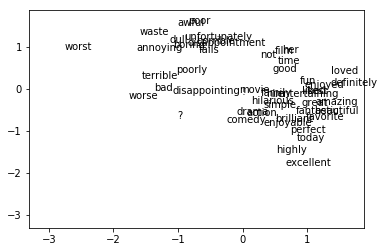

In [13]:
import numpy as np
import matplotlib.pyplot as plt

embedding_matrix = classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')

for term_index in range(len(informative_terms)):
  # Create a one-hot encoding for our term.  It has 0s everywhere, except for
  # a single 1 in the coordinate that corresponds to that term.
  term_vector = np.zeros(len(informative_terms))
  term_vector[term_index] = 1
  # We'll now project that one-hot vector into the embedding space.
  embedding_xy = np.matmul(term_vector, embedding_matrix)
  plt.text(embedding_xy[0],
           embedding_xy[1],
           informative_terms[term_index])

# Do a little setup to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show() 

In [14]:
# Only train 10 steps
########################## YOUR CODE HERE ######################################
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)# Define the embedding column
feature_columns = [terms_embedding_column]# Define the feature columns

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(                                      #
  feature_columns= feature_columns, #
  hidden_units=[20,20],                                                       #
  optimizer=my_optimizer,                                                     #
)                    # Define the DNNClassifier
################################################################################

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=10)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
loss 17.32223
accuracy_baseline 0.5
global_step 10
recall 0.98
auc 0.5386457
prediction/mean 0.5151167
precision 0.50287354
label/mean 0.5
average_loss 0.69288915
auc_precision_recall 0.51065606
accuracy 0.5056
---
Test set metrics:
loss 17.319815
accuracy_baseline 0.5
global_step 10
recall 0.98128
auc 0.53905576
prediction/mean 0.5151192
precision 0.5042549
label/mean 0.5
average_loss 0.6927926
auc_precision_recall 0.4728979
accuracy 0.50828
---


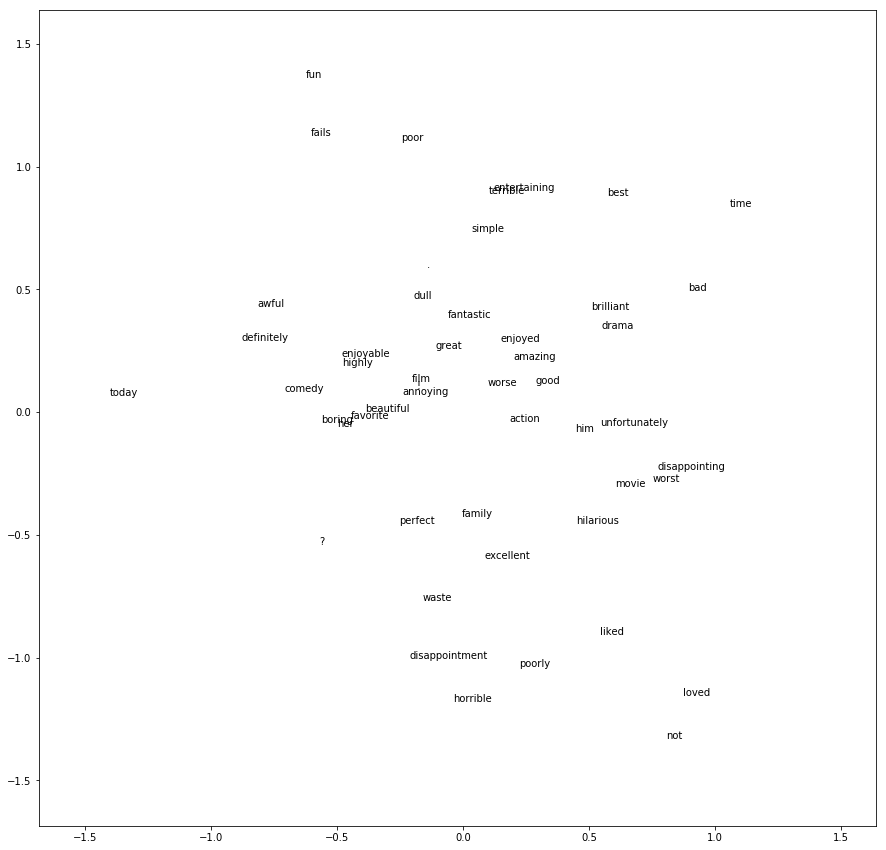

In [15]:
embedding_matrix = classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')

for term_index in range(len(informative_terms)):
  # Create a one-hot encoding for our term.  It has 0s everywhere, except for
  # a single 1 in the coordinate that corresponds to that term.
  term_vector = np.zeros(len(informative_terms))
  term_vector[term_index] = 1
  # We'll now project that one-hot vector into the embedding space.
  embedding_xy = np.matmul(term_vector, embedding_matrix)
  plt.text(embedding_xy[0],
           embedding_xy[1],
           informative_terms[term_index])

# Do a little setup to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show() 

Assignment 6:尝试改进模型的效果

In [16]:
# Download the vocabulary file.
terms_url = 'https://download.mlcc.google.cn/mledu-datasets/sparse-data-embedding/terms.txt'
terms_path = tf.keras.utils.get_file(terms_url.split('/')[-1], terms_url)

262144/253538 [===============================] - 1s 3us/step


In [17]:
# Create a feature column from "terms", using a full vocabulary file.
informative_terms = None
with io.open(terms_path, 'r', encoding='utf8') as f:
  # Convert it to a set first to remove duplicates.
  informative_terms = list(set(f.read().split()))
  
terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", 
                                                                                 vocabulary_list=informative_terms)

terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[10,10],
  optimizer=my_optimizer
)

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
loss 9.905153
accuracy_baseline 0.5
global_step 1000
recall 0.8568
auc 0.9043714
prediction/mean 0.5211776
precision 0.8099524
label/mean 0.5
average_loss 0.39620614
auc_precision_recall 0.9010698
accuracy 0.82788
---
Test set metrics:
loss 10.4729395
accuracy_baseline 0.5
global_step 1000
recall 0.83472
auc 0.8905474
prediction/mean 0.51815635
precision 0.79862225
label/mean 0.5
average_loss 0.41891757
auc_precision_recall 0.88535297
accuracy 0.81212
---


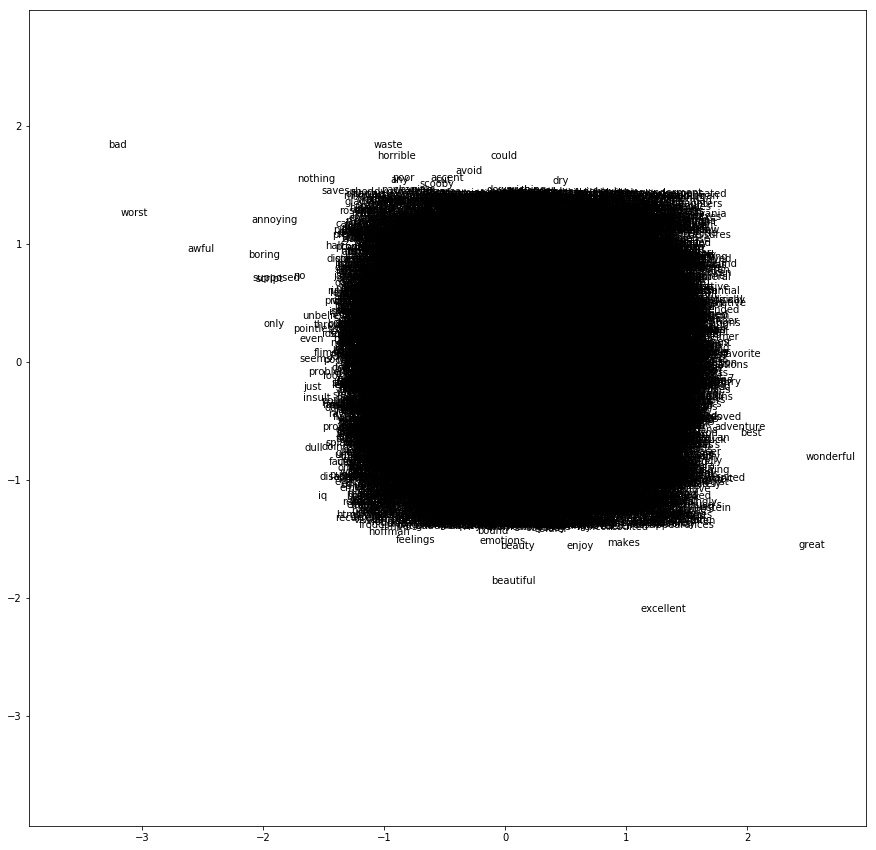

In [18]:
embedding_matrix = classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')

for term_index in range(len(informative_terms)):
  # Create a one-hot encoding for our term.  It has 0s everywhere, except for
  # a single 1 in the coordinate that corresponds to that term.
  term_vector = np.zeros(len(informative_terms))
  term_vector[term_index] = 1
  # We'll now project that one-hot vector into the embedding space.
  embedding_xy = np.matmul(term_vector, embedding_matrix)
  plt.text(embedding_xy[0],
           embedding_xy[1],
           informative_terms[term_index])

# Do a little setup to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show() 